# Part 3 - Data Science Stack

1. Perform density estimation using following algorithms: 

    a. Kernel Density Estimator (KDE) with Gaussian kernel.
    
    b. Gaussian Mixture Model (GMM).

2. Approximate and plot marginal distributions.

3. Search for the smallest bandwidth value for the KDE.

## **Import libraries**

In [112]:
# For loading dataset
from sklearn import datasets

# For creating density models
from sklearn.mixture import GMM
from sklearn.neighbors import KernelDensity
from scipy.stats import kde

# For ploting
import matplotlib.pyplot as plt


import numpy as np

## **Generate some cluster 2D data**

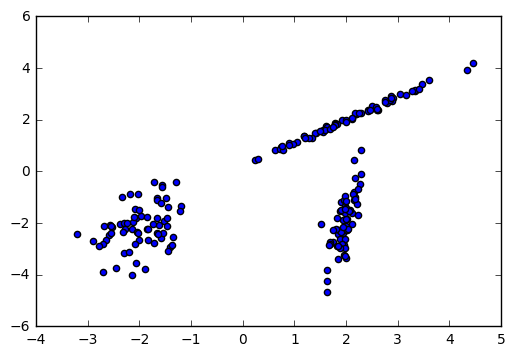

In [113]:
D, _ = datasets.make_classification(n_samples=200,
                                    n_features=2,
                                    n_informative=2,
                                    n_redundant=0,
                                    n_classes=3,
                                    n_clusters_per_class=1,
                                    class_sep=2)

x, y = D[:,0], D[:,1]
plt.scatter(x, y)
plt.show()

## **Display the density histograms to get some ideas about the density of the given data.**

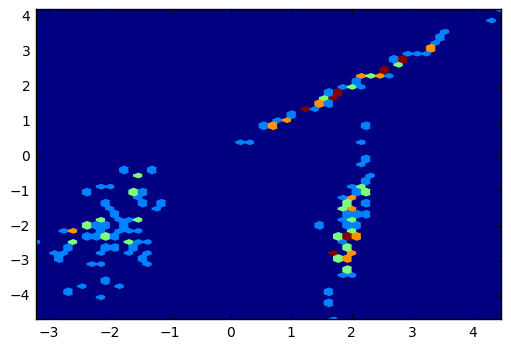

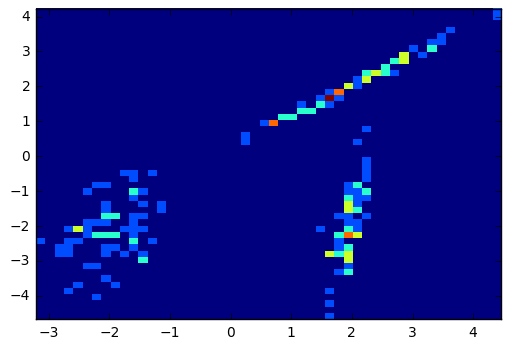

In [114]:
nbins=50
plt.hexbin(x, y, gridsize=nbins)
plt.show()

plt.hist2d(x, y, bins=nbins)
plt.show()

# **1. Perform density estimation using Kernel Density Estimator (KDE) with Gaussian kernel**

KED with *scipy* 

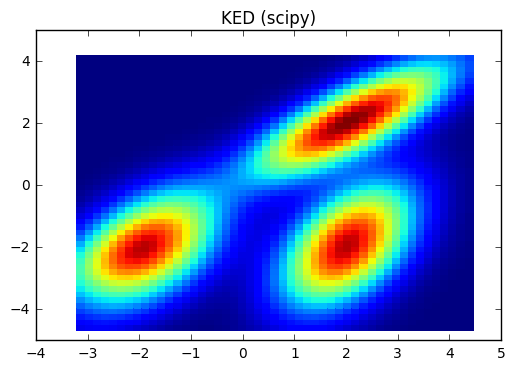

In [115]:
k = kde.gaussian_kde(D.T)

X, Y = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]

Z = k(np.vstack([X.flatten(), Y.flatten()]))

plt.pcolormesh(X, Y, Z.reshape(X.shape))
plt.title("KED (scipy)")
plt.show()

KDE with *sklearn*

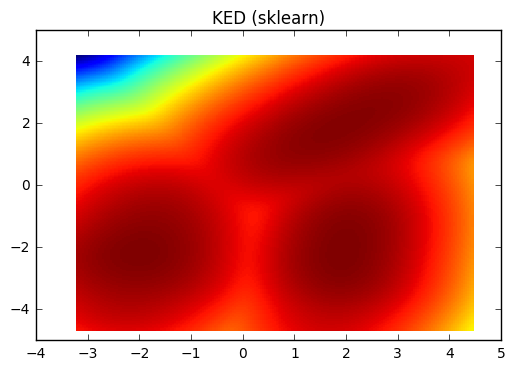

In [116]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.6).fit(D)

X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 200), np.linspace(y.min(), y.max(), 200))
XX = np.array([X.ravel(), Y.ravel()]).T

Z = kde.score_samples(XX)

plt.pcolormesh(X, Y, Z.reshape(X.shape))
plt.title("KED (sklearn)")
plt.show()

**Note** 

Bandwidth selection strongly influences the estimate obtained from the KDE.
*scipy* includes automatic bandwidth determination.
For the details of bandwidth selection in *scipy*, we refer to:
https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.stats.gaussian_kde.html

That's why in the heatmap of the KDE created with *scipy* makes more sense than the heatmap of the KDE created with *sklearn*. In *sklearn*, we choose the bandwidth manually.

GMM

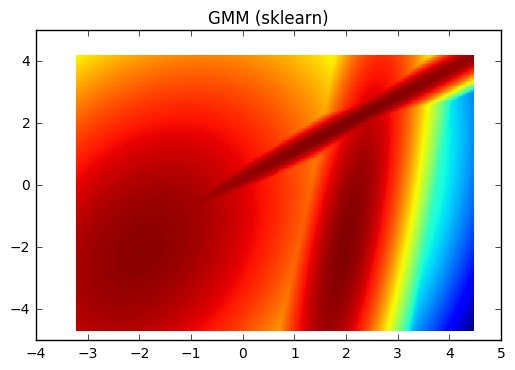

In [117]:
gmm = GMM(n_components=3, covariance_type='full')
gmm.fit(D)

Z, _ = gmm.score_samples(XX)

plt.pcolormesh(X, Y, Z.reshape(X.shape))
plt.title("GMM (sklearn)")
plt.show()

# **2. Approximate marginal distributions**

Generate some samples

In [122]:
nb_samples = 200
x_plot = np.linspace(x.min(), x.max(), nb_samples)
y_plot = np.linspace(y.min(), y.max(), nb_samples)

Fit the data x with a KDE

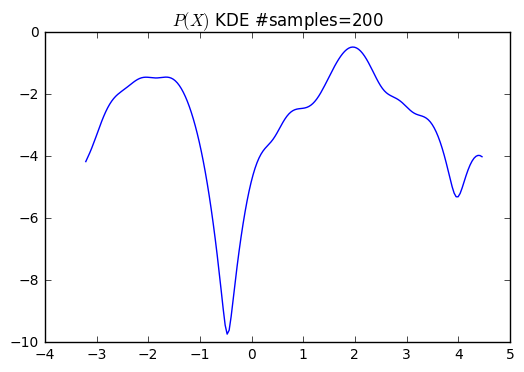

In [123]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(x.reshape(-1, 1))

px = kde.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, px)
plt.title("$P(X)$ KDE #samples=%d" % (nb_samples))
plt.show()

Fit data x with a GMM

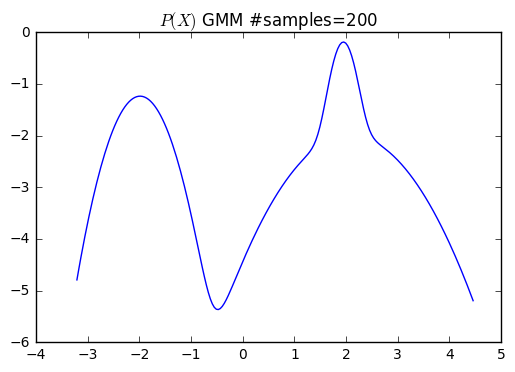

In [124]:
gmm = GMM(n_components=3, covariance_type='full')
gmm.fit(x.reshape(-1, 1))

px, _ = gmm.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, px)
plt.title("$P(X)$ GMM #samples=%d" % (nb_samples))
plt.show()

Fit data y with a KDE

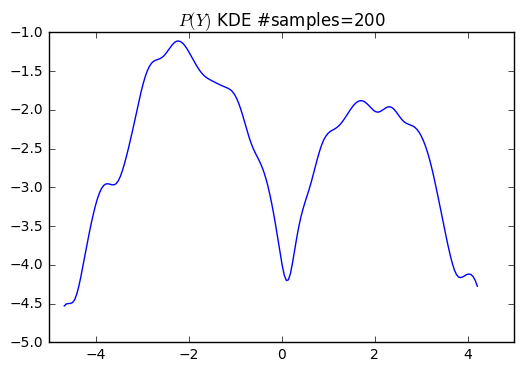

In [125]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(y.reshape(-1, 1))

py = kde.score_samples(y_plot.reshape(-1, 1))

plt.plot(y_plot, py)
plt.title("$P(Y)$ KDE #samples=%d" % (nb_samples))
plt.show()

Fit data y with a GMM

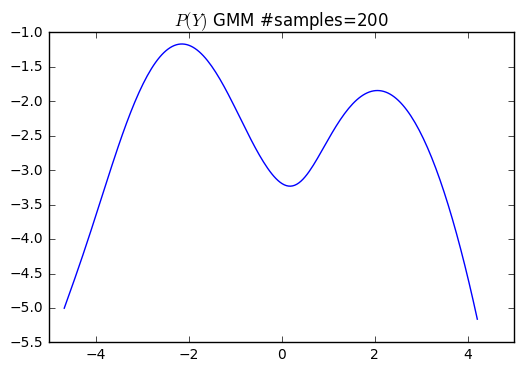

In [126]:
gmm = GMM(n_components=3, covariance_type='full')
gmm.fit(y.reshape(-1, 1))

py, _ = gmm.score_samples(y_plot.reshape(-1, 1))

plt.plot(y_plot, py)
plt.title("$P(Y)$ GMM #samples=%d" % (nb_samples))
plt.show()

# 3. Choose bandwidth of KDE

Create some data

In [127]:
nb_samples = 200

X, Y = np.meshgrid(np.linspace(x.min(), x.max(), nb_samples), np.linspace(y.min(), y.max(), nb_samples))

XX = np.array([X.ravel(), Y.ravel()]).T

Linear search method

In [128]:
def get_optimal_bandwidth_lin(D, scores_groundtruth, epochs=10, initial_bandwidth=1, step_size=-0.1):
    """
    Choose bandwidth of KDE by linear search.
    Note: Based on some observations, we assume that 
    when decreasing the bandwidth the output scores of the KDE are similar to the output scores of the GMM.
    
    Parameters
    -----------------
    D: 2D data.
    
    scores_groundtruth: the expected scores we want to get with the KDE by using the selected bandwidth.
    
    epochs: the number of epochs that we wish to run the searching algorithm.
    
    initial_bandwidth: the initial bandwidth.
    
    step_size: the change of bandwidth in each epoch.
    
    Return
    -----------------
    bandwidth: selected bandwidth.
    
    errors: a list contains the difference between the scores in each epochs of the KED 
    and the expected scores.
    
    epochs: number of epochs used. 
    Note: the algorithm may stop before the expected number of epochs. 
    """ 

    bandwidth = initial_bandwidth
    errors = []
    previous_error = float("inf")
    
    for i in range(epochs):
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(D)
        
        scores_kde = kde.score_samples(XX)
        
        # use L2-norm as cost function to compute difference between the scores of KDE ans the real scores
        error = np.linalg.norm(np.array(scores_groundtruth) - np.array(scores_kde))
        
        print("epochs = %d, error = %f" % (i+1, error))
        errors.append(error)
        
        # stop loop when error does not decrease too much
        if(error >= previous_error):
            del errors[-1]
            bandwidth = bandwidth - step_size
            return bandwidth, errors, i
        
        bandwidth = bandwidth + step_size
        previous_error = error

    return bandwidth, errors, epochs

epochs = 1, error = 6905.661091
epochs = 2, error = 6866.979412
epochs = 3, error = 6812.131368
epochs = 4, error = 6733.097683
epochs = 5, error = 6617.335348
epochs = 6, error = 6447.524689
epochs = 7, error = 6220.894845
epochs = 8, error = 6161.643451
epochs = 9, error = 8772.145174


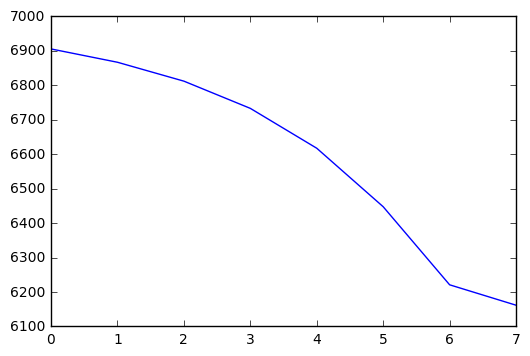

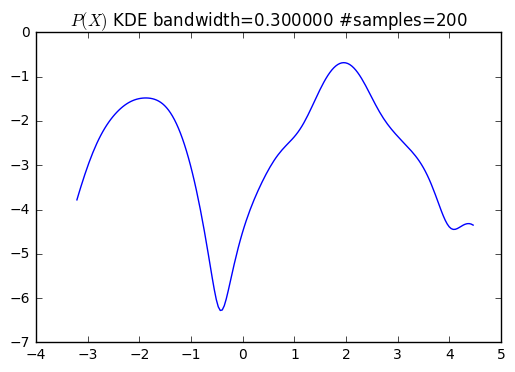

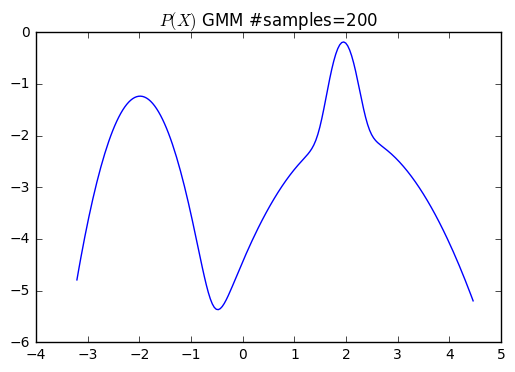

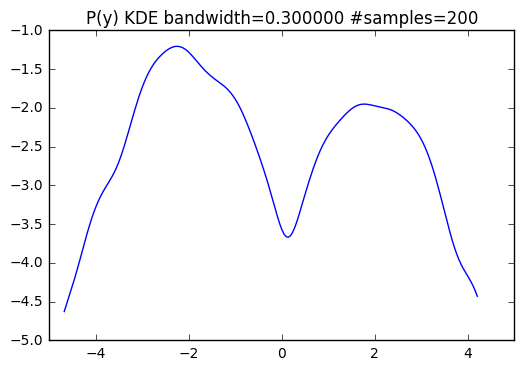

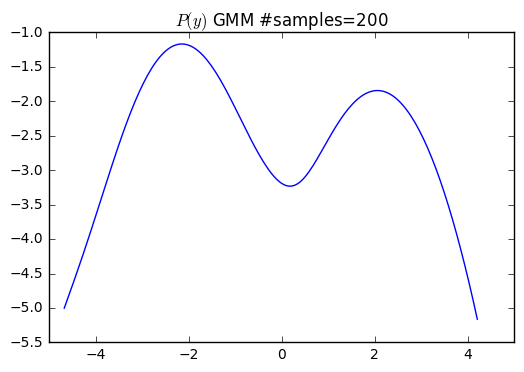

In [129]:
# Initialize the parameters for bandwidth searching
epochs=50
initial_bandwidth=1
step_size=-0.1

# Compute scores of GMM and consider these scores as our ground truth scores (i.e., the scores we wish to obtain)
gmm = GMM(n_components=3, covariance_type='full')
gmm.fit(D)
scores_gmm, _ = gmm.score_samples(XX)

# Search bandwidth of KDE, in order to get similar scores as GMM.
bandwidth, errors, nb_iterations = get_optimal_bandwidth_lin(D,
                                                         scores_groundtruth=scores_gmm,
                                                         epochs=epochs,
                                                         initial_bandwidth=initial_bandwidth,
                                                         step_size=step_size)
plt.plot(range(nb_iterations), errors)
plt.show()


# Fit the data x with a KED
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(x.reshape(-1, 1))
px = kde.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, px)
plt.title("$P(X)$ KDE bandwidth=%f #samples=%d" % (bandwidth, nb_samples))
plt.show()

# Fit the data x with GMM
gmm = GMM(n_components=3, covariance_type='full')
gmm.fit(x.reshape(-1, 1))
px, _ = gmm.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, px)
plt.title("$P(X)$ GMM #samples=%d" % (nb_samples))
plt.show()

# Fit the data y with a KED
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(y.reshape(-1, 1))
py = kde.score_samples(y_plot.reshape(-1, 1))

plt.plot(y_plot, py)
plt.title("P(y) KDE bandwidth=%f #samples=%d" % (bandwidth, nb_samples))
plt.show()

# Fit the data y with GMM
gmm = GMM(n_components=3, covariance_type='full')
gmm.fit(y.reshape(-1, 1))
py, _ = gmm.score_samples(y_plot.reshape(-1, 1))

plt.plot(y_plot, py)
plt.title("$P(y)$ GMM #samples=%d" % (nb_samples))
plt.show()

Binary search method

In [130]:
def get_optimal_bandwidth_bin(D, scores_groundtruth, initial_bandwidth=1, smallest_bandwidth=0.1, episilon=0.1):
    """
    Choose bandwidth of the KDE by linear search.
    Note: Based on some observations, we assume that 
    when decreasing the bandwidth the output scores of the KDE are similar to the output scores of the GMM.
    
    Parameters
    ---------------
    D: 2D dataset
    
    scores_groundtruth: the real scores we want to obtain with the KDE by using the selected bandwidth.
    
    initial_bandwidth: the initial bandwidth, i.e., the biggest bandwidth
    
    smallest_bandwidth: the smallest bandwith.
    
    episilion: the minimum range of the middle bandwidth to the smallest bandwidth, 
    i.e., if the distance between the smallest bandwidth and the middle bandwidth is less than episilion, 
    then the algorithm stops
    
    
    Returns
    ---------------
    bandwidth: selected bandwidth.
    
    optimal_errors: a list contains the difference between 
    the scores of the KDE in each iteration and the expected scores.
    
    nb_iteration: number of iteration of the searching.
    
    """
    
    # a list contains three bandwidth values, i.e., left (biggest), right (smallest), and middle.
    bandwidth = [initial_bandwidth, (initial_bandwidth+smallest_bandwidth)/2, smallest_bandwidth]
    
    # errors obtained with the three bandwidth values.
    errors = [0, 0, 0]
    
    # errors of the middle bandwidth.
    optimal_errors = []
    
    nb_iteration = 0
    
    # compute the scores of the KDEs with the left and right bandwidth
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth[0]).fit(D)
    # use L2-norm as cost function to compute difference between the scores of KDE and expected scores.
    errors[0] = np.linalg.norm(np.array(scores_groundtruth) - np.array(kde.score_samples(XX)))
    
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth[2]).fit(D)
    errors[2] = np.linalg.norm(np.array(scores_groundtruth) - np.array(kde.score_samples(XX)))
    
    while True:
        # compute the scores of the KDE with the middle bandwidth.
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth[1]).fit(D)
        
        # use L2-norm as cost function to compute difference between the scores of KDE and expected scores.
        errors[1] = np.linalg.norm(np.array(scores_groundtruth) - np.array(kde.score_samples(XX)))
        
        nb_iteration += 1
        optimal_errors.append(errors[1])
        print("epochs = %d, error = %f" % (nb_iteration, errors[1]))
        
        # update the left and middle bandwidth,
        # so the new searching will start in the two bandwidth where we achieve two minimum errors.
        bandwidth = [b for (e, b) in sorted(zip(errors, bandwidth))]
        bandwidth[2] = bandwidth[1]
        bandwidth[1] = (bandwidth[0] + bandwidth[1])/2
        sorted(errors)
        
        if(abs(bandwidth[0]-bandwidth[1]) < episilon):
            return bandwidth[1], optimal_errors, nb_iteration
        
    return bandwidth[1], optimal_errors, nb_iteration

epochs = 1, error = 6540.296249
epochs = 2, error = 6795.039569
epochs = 3, error = 6694.842997


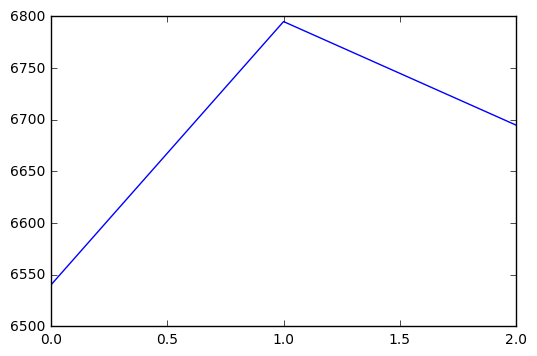

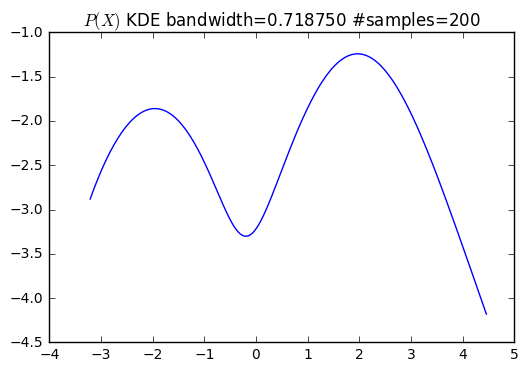

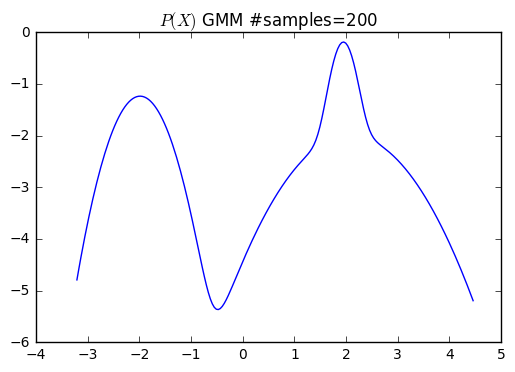

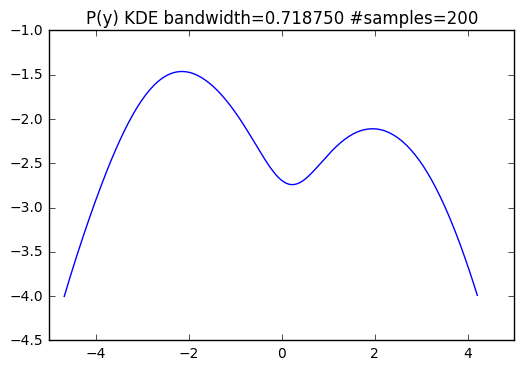

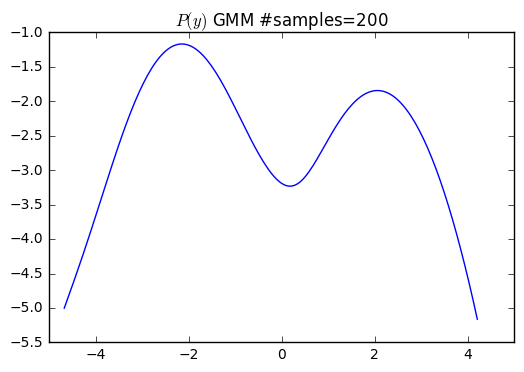

In [131]:
# Compute scores of GMM and consider these scores as our ground truth scores (i.e., the scores we wish to obtain)
gmm = GMM(n_components=3, covariance_type='full')
gmm.fit(D)
scores_gmm, _ = gmm.score_samples(XX)

# Search bandwidth of KDE, in order to get similar scores as GMM.
bandwidth, errors, nb_iterations = get_optimal_bandwidth_bin(D,
                                                             scores_groundtruth=scores_gmm,
                                                             initial_bandwidth=1,
                                                             smallest_bandwidth=0.1)

plt.plot(range(nb_iterations), errors)
plt.show()

# Fit the data x with a KED
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(x.reshape(-1, 1))
px = kde.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, px)
plt.title("$P(X)$ KDE bandwidth=%f #samples=%d" % (bandwidth, nb_samples))
plt.show()

# Fit the data x with GMM
gmm = GMM(n_components=3, covariance_type='full')
gmm.fit(x.reshape(-1, 1))
px, _ = gmm.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, px)
plt.title("$P(X)$ GMM #samples=%d" % (nb_samples))
plt.show()

# Fit the data y with a KED
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(y.reshape(-1, 1))
py = kde.score_samples(y_plot.reshape(-1, 1))

plt.plot(y_plot, py)
plt.title("P(y) KDE bandwidth=%f #samples=%d" % (bandwidth, nb_samples))
plt.show()

# Fit the data y with GMM
gmm = GMM(n_components=3, covariance_type='full')
gmm.fit(y.reshape(-1, 1))
py, _ = gmm.score_samples(y_plot.reshape(-1, 1))

plt.plot(y_plot, py)
plt.title("$P(y)$ GMM #samples=%d" % (nb_samples))
plt.show()